# Training the BBB predictor with sign3 from the paper checker

## Nicolas, 19 Nov. 2020

In [26]:
%matplotlib inline
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
sns.set_style("whitegrid")

# Martino's signaturizer
from signaturizer import Signaturizer

# Machine learning part
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Hyper parameter tuning with CV
from sklearn.model_selection import GridSearchCV

# Deepchem (includes MoleculeNet)
import rdkit.Chem as Chem
from rdkit.Chem.Scaffolds import MurckoScaffold 
#from deepchem.splits import ScaffoldSplitter

# conda install -c conda-forge hyperopt 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# For saving ML models
import joblib

In [2]:
# load the predictor for ALL spaces (the global signature)
sign = Signaturizer('GLOBAL')

In [ ]:
# #Chemical checker if the global SIGN3 have not been saved in .npy files
# RUN with a singularity image
#from chemicalchecker import ChemicalChecker
# os.environ["CC_CONFIG"] = "/home/nsoler/CODE/chemical_checker/setup/cc_config.json"
#cc =ChemicalChecker("/aloy/web_checker/package_cc/paper/")
#universe=set(cc.universe)

## Functions

In [3]:
# Using rdkit function to get the Murcko scaffold of each molecule
def murcko(smiles_str, include_chirality=True):
    #chemical_checker/package/chemicalchecker/tool/targetmate/utils/chemistry.py

    try:
        #m = Chem.MolFromSmiles(smile_str)
        #return Chem.MolToSmiles(GetScaffoldForMol(m))
        #-> copied form the cc splitter util 
        mol = Chem.MolFromSmiles(smiles_str)
        if mol is not None:
            return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)
        else:
            return 'none'

    except Exception as e:
        print("WARNING, problem for generating scaffold for:", smile_str)
        print(e,'\n')
        return 'none'


def customSplitter(dfin,ratio=0.2, random_state=42,INITCYCLES=200, MAXCYCLES=1000):
    """Make a 80:20 train, test set 
    by ensuring that the scaffolds in the train set are absent in the test set.
    and that the proportion (+/-) is conserved
    We
    returns the list of indices from the original df
    """
    valcount=dfin.p_np.value_counts()
    
    prop0= valcount[0]/(valcount[0] + valcount[1]) # proportion of y==1
    prop1= 1 - prop0                               # proportion of y =0
    
    print("Balance 1/0:", prop1,prop0)
    print("\n")

    moltest=0                                      # proportion of molecules to isolate for the test_set
    Ntot = len(dfin)
    test_lst=[]                            # list of indices form the dataframe to take as test
    scaffold_test =set()
    scaffold_train = set(dfin.scaffold.unique())
    p1=0
    n1=0
    c=0
    
    while moltest < ratio:

        # Take s scaffold at random and append its molecules
        # here scaffold is an aggregation
        # so indices are the scaffolds and each value is a list df indices where the scaffold is present
        sample=scaffoldsSeries.sample(1)                   # take a sample of dataframe indices at random
        idx_lst=sample.values.tolist()[0]
        scaf = sample.index.tolist()[0]
        
        if c>MAXCYCLES:
            print("MAXCYCLES")
            return test_lst
        
        if scaf in scaffold_train: # each time we choose a new scaffold
        
            for idx in idx_lst:    # for each molecule of this scaffold
                c+=1
                moltest= len(test_lst) / len(dfin)
                yval=df.loc[idx,'p_np']  # 1 or 0
                
                if c<INITCYCLES or (moltest<ratio and idx not in test_lst and p1<prop1):
                    test_lst.append(idx)

                    if yval == 1:              # keep the number of 1 below the required proportion
                        n1 += 1
                        p1 = n1 / len(test_lst)
                        
                        # print the cycle number, proportion of 1 in test set, proportion of obs in test set
                        print('cycle:',c,'1_p:', p1, 'test_p:',moltest)
                    
            scaffold_test.add(scaf)
            scaffold_train.remove(scaf)
    

    return test_lst

def formatArray(x):
    return np.array(list([list(l) for l in x]))

### Loading the BBB data

In [4]:
# Loading the downloaded data
df = pd.read_csv("../DATA/BBBP.csv")
df['num'] = df.num.apply(lambda x: int(x))
df.set_index('num',inplace=True)

# Creating a new column in the dataset
df['scaffold']=df.smiles.apply(murcko)

# Replace emply scaffold by the string 'empty'
df.loc[df.scaffold=='','scaffold']='empty'
df[df.scaffold=='empty']

df

,name,p_np,smiles,scaffold
num,,,,
1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,c1ccc2ccccc2c1
2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,c1ccccc1
3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,O=c1ccn2c3c(c(N4CCNCC4)ccc13)OCC2
4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,c1ccc(CN2CCCCC2)cc1
5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,O=C(N[C@@H]1C(=O)N2CCS[C@H]12)c1conc1-c1ccccc1
...,...,...,...,...
2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,O=c1[nH]c2ccccc2[nH]c1=O
2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,c1ncc2ncn([C@H]3CCCO3)c2n1
2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,O=C([N-]c1cn(CCc2ccccc2)n[o+]1)Nc1ccccc1


In [34]:
df[df.name=='nicotine']

,name,p_np,smiles,scaffold,sign3,hassign3,signZ,hassignZ
num,,,,,,,,
718,nicotine,1,CN1CCC[C@H]1c2cccnc2,c1cncc([C@@H]2CCCN2)c1,"[0.084169924, -0.092190646, 0.09219373, 0.0620...",1,"[0.007463507, -0.059746753, 0.096984535, 0.068...",1


In [ ]:
# try to remove molecules with empty scaffold
#df.drop(df[df.scaffold=='empty'].index,inplace=True)

In [5]:
df.scaffold.value_counts()

c1ccccc1                                      137
empty                                          99
O=C1C=CC2C(=C1)CC[C@@H]1C2CCC2CCC[C@H]21       32
c1ccc2c(c1)Nc1ccccc1S2                         26
O=C1CN=C(c2ccccc2)c2ccccc2N1                   26
                                             ... 
O=c1ccc2c(c1)[nH]c1c[nH]ccc12                   1
c1ccc2c(c1)C[C@@H]1CC2CCN1                      1
C1=C(c2ccccc2)CCNC1                             1
O=c1cccn[nH]1                                   1
O=C(NC1C[C@@H]2CC[C@H](C1)N2)N1CCc2ccccc21      1
Name: scaffold, Length: 1103, dtype: int64

2050 observations
1    1567
0     483
Name: p_np, dtype: int64


<AxesSubplot:>

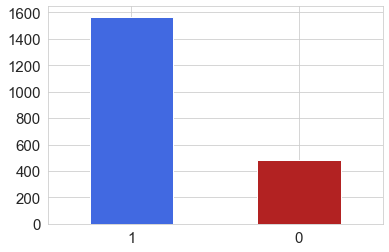

In [6]:
# Check if we are well balanced, not that well..
print(len(df), 'observations')
print(df.p_np.value_counts())
df.p_np.value_counts().plot.bar(color=['royalblue','firebrick'],rot=0,fontsize=15)

### Try to retrieve the global sign3 for each of these molecules in the checker

### Fetching the global signature for all (CC-covered molecules)

In [7]:
# The global signatures were saved as npy files, don't recalculate if they are already available
npyfiles= glob.glob('../SIGNATURES/paper/*.npy')


if len(npyfiles) <1:
    df['sign3']= df.smiles.apply(lambda x: cc.get_global_signature(x, str_type='smiles'))
else:
    df['sign3']='none'
    for npf in sorted(npyfiles,key=lambda x: int(x.split('/')[-1].split('.')[0])):
        print("\n",npf)
        arr = np.load(npf, allow_pickle=True)
        num=int(os.path.basename(npf).split('.')[0])
        if None not in arr and 'none' not in arr and num in df.index:
            df.at[num, 'sign3']=arr
            print(num,repr(arr))
        else:
            print(num,'NO SIGNATURE')

# Tag them
df['hassign3'] = df.sign3.apply(lambda x:1 if x != 'none' else 0)


 ../SIGNATURES/paper/1.npy
1 NO SIGNATURE

 ../SIGNATURES/paper/2.npy
2 NO SIGNATURE

 ../SIGNATURES/paper/3.npy
3 array([-0.08540896, -0.09176911,  0.09176902, ..., -0.09074245,
       -0.09074245, -0.09074245], dtype=float32)

 ../SIGNATURES/paper/4.npy
4 NO SIGNATURE

 ../SIGNATURES/paper/5.npy
5 array([ 0.09180188, -0.09180276,  0.09167028, ...,  0.08921022,
        0.08921022, -0.08921022], dtype=float32)

 ../SIGNATURES/paper/6.npy
6 array([ 0.09083176, -0.09083176, -0.09077182, ..., -0.09009816,
       -0.08982863, -0.09010281], dtype=float32)

 ../SIGNATURES/paper/7.npy
7 NO SIGNATURE

 ../SIGNATURES/paper/8.npy
8 array([ 0.08963323, -0.08963329,  0.08963329, ..., -0.07236993,
        0.089512  ,  0.08949578], dtype=float32)

 ../SIGNATURES/paper/9.npy
9 array([-0.09104717, -0.0910477 ,  0.0910477 , ..., -0.06105838,
        0.09030443,  0.09050114], dtype=float32)

 ../SIGNATURES/paper/10.npy
10 array([-0.08996463,  0.08996463,  0.08987556, ..., -0.08876373,
       -0.0889659

/home/nicolas/anaconda3/envs/sign/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


15 array([-0.090871  , -0.0907275 ,  0.090871  , ..., -0.09013995,
        0.07164041,  0.09014163], dtype=float32)

 ../SIGNATURES/paper/16.npy
16 array([-0.08997396, -0.08998196,  0.08998196, ..., -0.09203611,
        0.09205952, -0.09200883], dtype=float32)

 ../SIGNATURES/paper/17.npy
17 array([-0.09070552, -0.09070552,  0.09070552, ..., -0.10168494,
        0.11423608, -0.12541157], dtype=float32)

 ../SIGNATURES/paper/18.npy
18 NO SIGNATURE

 ../SIGNATURES/paper/19.npy
19 array([ 0.09086433, -0.09086433,  0.09086433, ...,  0.08914877,
        0.08914877, -0.08914877], dtype=float32)

 ../SIGNATURES/paper/20.npy
20 array([ 0.09063586,  0.09063586, -0.09063586, ...,  0.08924158,
       -0.08923318, -0.08924158], dtype=float32)

 ../SIGNATURES/paper/21.npy
21 NO SIGNATURE

 ../SIGNATURES/paper/22.npy
22 array([-0.08928347,  0.08928347, -0.08928347, ...,  0.08872417,
       -0.08872417, -0.08872417], dtype=float32)

 ../SIGNATURES/paper/23.npy
23 NO SIGNATURE

 ../SIGNATURES/paper/24

106 array([-0.09170929,  0.09170929,  0.00742256, ...,  0.05092196,
       -0.09443317,  0.09435698], dtype=float32)

 ../SIGNATURES/paper/107.npy
107 array([ 0.09152889, -0.09152889,  0.09151656, ...,  0.08891723,
        0.08891723, -0.08891723], dtype=float32)

 ../SIGNATURES/paper/108.npy
108 array([ 0.09276168, -0.09276168,  0.0927477 , ...,  0.08860121,
        0.08860121, -0.08860121], dtype=float32)

 ../SIGNATURES/paper/109.npy
109 array([-0.08941625,  0.08942706, -0.08942594, ..., -0.09823545,
       -0.11431422,  0.03330163], dtype=float32)

 ../SIGNATURES/paper/110.npy
110 NO SIGNATURE

 ../SIGNATURES/paper/111.npy
111 array([ 0.09144422, -0.08210684,  0.09144409, ...,  0.0890898 ,
        0.0890898 , -0.0890898 ], dtype=float32)

 ../SIGNATURES/paper/112.npy
112 array([-0.08927626, -0.08927626,  0.08927626, ...,  0.03895813,
       -0.1099283 , -0.07736103], dtype=float32)

 ../SIGNATURES/paper/113.npy
113 array([-0.09037921, -0.09037921,  0.09037921, ..., -0.09173129,
   

 ../SIGNATURES/paper/171.npy
171 array([-0.09037258,  0.09037258, -0.09037258, ...,  0.08863309,
       -0.08863309,  0.08863309], dtype=float32)

 ../SIGNATURES/paper/172.npy
172 array([ 0.09159051, -0.09159071, -0.09159071, ...,  0.03482392,
        0.13975935,  0.05774055], dtype=float32)

 ../SIGNATURES/paper/173.npy
173 array([-0.09319121, -0.09328761, -0.09327538, ..., -0.09092178,
        0.09104389, -0.09039793], dtype=float32)

 ../SIGNATURES/paper/174.npy
174 array([-0.09000529, -0.09075289,  0.09075289, ..., -0.09305353,
        0.09309756,  0.09308103], dtype=float32)

 ../SIGNATURES/paper/175.npy
175 array([-0.08961343,  0.08961343,  0.0896134 , ..., -0.08961859,
        0.08961874,  0.0867982 ], dtype=float32)

 ../SIGNATURES/paper/176.npy
176 array([-0.08915962,  0.08915962, -0.08915962, ..., -0.09210284,
       -0.09210284, -0.09120974], dtype=float32)

 ../SIGNATURES/paper/177.npy
177 NO SIGNATURE

 ../SIGNATURES/paper/178.npy
178 array([ 0.09323493, -0.09323508,  0.09

240 array([-0.03563573,  0.09161562, -0.09161562, ..., -0.08857843,
       -0.08857843, -0.08857843], dtype=float32)

 ../SIGNATURES/paper/241.npy
241 array([ 0.0905214 , -0.0905214 , -0.0905214 , ..., -0.09315035,
        0.09323141, -0.07313298], dtype=float32)

 ../SIGNATURES/paper/242.npy
242 array([-0.08988912, -0.08988912,  0.08988912, ...,  0.06415205,
        0.09120591, -0.09137916], dtype=float32)

 ../SIGNATURES/paper/243.npy
243 array([-0.08966076, -0.07410485,  0.08966082, ..., -0.06997444,
       -0.0892795 , -0.08393981], dtype=float32)

 ../SIGNATURES/paper/244.npy
244 array([-0.09277175,  0.09277178,  0.09277178, ...,  0.08886403,
       -0.08886403,  0.08886403], dtype=float32)

 ../SIGNATURES/paper/245.npy
245 array([-0.08989177, -0.08989168,  0.08989177, ...,  0.08852857,
       -0.08852857,  0.08852857], dtype=float32)

 ../SIGNATURES/paper/246.npy
246 array([-0.08993973, -0.08993973,  0.08993973, ..., -0.08875231,
        0.08875231, -0.08875231], dtype=float32)



310 array([-0.08950187,  0.08961835, -0.08961835, ...,  0.08980718,
       -0.08980718,  0.0898071 ], dtype=float32)

 ../SIGNATURES/paper/311.npy
311 NO SIGNATURE

 ../SIGNATURES/paper/312.npy
312 array([ 0.09136862, -0.09136923,  0.09136586, ..., -0.08166704,
        0.10309622,  0.0483948 ], dtype=float32)

 ../SIGNATURES/paper/313.npy
313 NO SIGNATURE

 ../SIGNATURES/paper/314.npy
314 array([-0.08963338, -0.08963338,  0.08963338, ...,  0.11153671,
       -0.10383638, -0.04316517], dtype=float32)

 ../SIGNATURES/paper/315.npy
315 array([ 0.08238567, -0.08993228,  0.08993228, ..., -0.0889824 ,
        0.0889824 ,  0.0889824 ], dtype=float32)

 ../SIGNATURES/paper/316.npy
316 array([ 0.09096875, -0.09096875, -0.09096875, ...,  0.08723022,
        0.09186952,  0.09082606], dtype=float32)

 ../SIGNATURES/paper/317.npy
317 array([ 0.08990443, -0.08990443, -0.08990443, ...,  0.09004537,
        0.09038425,  0.06430058], dtype=float32)

 ../SIGNATURES/paper/318.npy
318 array([-0.09052832, 

 ../SIGNATURES/paper/400.npy
400 array([-0.08927909, -0.08960257, -0.08960257, ..., -0.1043113 ,
       -0.10363592,  0.05818075], dtype=float32)

 ../SIGNATURES/paper/401.npy
401 NO SIGNATURE

 ../SIGNATURES/paper/402.npy
402 array([-0.09115312, -0.0911546 ,  0.0911546 , ...,  0.07193951,
        0.09029868, -0.00496815], dtype=float32)

 ../SIGNATURES/paper/403.npy
403 array([ 0.08907309, -0.08907317, -0.08907317, ..., -0.09305017,
       -0.09174012,  0.02214759], dtype=float32)

 ../SIGNATURES/paper/404.npy
404 array([-0.0887223 ,  0.0887223 , -0.08809451, ..., -0.09655692,
       -0.09655282,  0.05082725], dtype=float32)

 ../SIGNATURES/paper/405.npy
405 array([ 0.0628437 , -0.0938412 , -0.09326772, ..., -0.09906372,
       -0.09908716, -0.06775675], dtype=float32)

 ../SIGNATURES/paper/406.npy
406 NO SIGNATURE

 ../SIGNATURES/paper/407.npy
407 NO SIGNATURE

 ../SIGNATURES/paper/408.npy
408 NO SIGNATURE

 ../SIGNATURES/paper/409.npy
409 array([-0.0946866 ,  0.09469941,  0.0904157 

 ../SIGNATURES/paper/478.npy
478 array([ 0.09034591,  0.09034599, -0.09034599, ...,  0.10519431,
        0.02120823, -0.00079231], dtype=float32)

 ../SIGNATURES/paper/479.npy
479 array([-0.09073851, -0.09073851,  0.09073851, ...,  0.06428755,
        0.00588259, -0.03435346], dtype=float32)

 ../SIGNATURES/paper/480.npy
480 array([-0.08930362, -0.08930346,  0.08930362, ...,  0.08637511,
        0.08627773, -0.08969886], dtype=float32)

 ../SIGNATURES/paper/481.npy
481 array([-0.09072375, -0.09072375,  0.09072375, ...,  0.0764558 ,
        0.08310579, -0.08942838], dtype=float32)

 ../SIGNATURES/paper/482.npy
482 array([-0.03450944, -0.09117407,  0.09117409, ...,  0.08884707,
       -0.08884708,  0.08884708], dtype=float32)

 ../SIGNATURES/paper/483.npy
483 array([-0.0891788 , -0.08946919, -0.08946919, ...,  0.08976839,
        0.09018982,  0.09008854], dtype=float32)

 ../SIGNATURES/paper/484.npy
484 array([-0.04398476,  0.0905006 , -0.09044924, ...,  0.09272271,
        0.08768622, -


 ../SIGNATURES/paper/565.npy
565 array([-0.09228235,  0.09228235, -0.09228235, ...,  0.13903318,
       -0.11351194, -0.07397342], dtype=float32)

 ../SIGNATURES/paper/566.npy
566 NO SIGNATURE

 ../SIGNATURES/paper/567.npy
567 array([-0.09110723,  0.09110723, -0.09110723, ...,  0.11986963,
        0.0751632 ,  0.06911071], dtype=float32)

 ../SIGNATURES/paper/568.npy
568 NO SIGNATURE

 ../SIGNATURES/paper/569.npy
569 NO SIGNATURE

 ../SIGNATURES/paper/570.npy
570 array([-0.08755132,  0.0898198 , -0.0898198 , ...,  0.09850044,
       -0.09619063,  0.09866213], dtype=float32)

 ../SIGNATURES/paper/571.npy
571 array([-0.09141678, -0.09141678,  0.09141678, ...,  0.08895546,
        0.08895546, -0.08895546], dtype=float32)

 ../SIGNATURES/paper/572.npy
572 array([-0.09145018, -0.09145023,  0.09144833, ..., -0.01231309,
        0.09023153,  0.00376865], dtype=float32)

 ../SIGNATURES/paper/573.npy
573 array([-0.08929245, -0.08929245,  0.08929245, ..., -0.09264828,
        0.09331144, -0.093

656 array([-0.09150127, -0.09150127,  0.09150127, ..., -0.0916998 ,
       -0.09169988,  0.09169032], dtype=float32)

 ../SIGNATURES/paper/657.npy
657 array([-0.09059439, -0.09054072,  0.09059439, ..., -0.0978419 ,
        0.10964351, -0.1093781 ], dtype=float32)

 ../SIGNATURES/paper/658.npy
658 array([-0.09022408, -0.09022408,  0.09022408, ..., -0.0903416 ,
        0.09034485, -0.09034485], dtype=float32)

 ../SIGNATURES/paper/659.npy
659 array([-0.08864477, -0.0910963 , -0.07559934, ...,  0.11970297,
       -0.10975002, -0.09739766], dtype=float32)

 ../SIGNATURES/paper/660.npy
660 NO SIGNATURE

 ../SIGNATURES/paper/661.npy
661 array([-0.08916301, -0.08916301,  0.08916301, ..., -0.09076842,
        0.09077165, -0.09077165], dtype=float32)

 ../SIGNATURES/paper/662.npy
662 NO SIGNATURE

 ../SIGNATURES/paper/663.npy
663 array([ 0.06162778,  0.09013203,  0.09013342, ...,  0.09026122,
        0.08496653, -0.09026122], dtype=float32)

 ../SIGNATURES/paper/664.npy
664 array([-0.09043258, 

 ../SIGNATURES/paper/743.npy
743 NO SIGNATURE

 ../SIGNATURES/paper/744.npy
744 array([ 0.09173491, -0.09173491,  0.09162257, ...,  0.09027393,
        0.09027393, -0.09027393], dtype=float32)

 ../SIGNATURES/paper/745.npy
745 NO SIGNATURE

 ../SIGNATURES/paper/746.npy
746 array([ 0.08926398,  0.08926412, -0.08926412, ..., -0.0263344 ,
        0.09508901,  0.09953035], dtype=float32)

 ../SIGNATURES/paper/747.npy
747 array([-0.08793264,  0.09066311, -0.09066311, ...,  0.12511876,
       -0.1265911 , -0.09488656], dtype=float32)

 ../SIGNATURES/paper/748.npy
748 array([-0.09588795, -0.09234519,  0.09335417, ...,  0.09031256,
       -0.09031137,  0.09031256], dtype=float32)

 ../SIGNATURES/paper/749.npy
749 NO SIGNATURE

 ../SIGNATURES/paper/750.npy
750 NO SIGNATURE

 ../SIGNATURES/paper/751.npy
751 array([-0.09106883,  0.09106883, -0.09106695, ...,  0.09596229,
        0.06878073, -0.08568524], dtype=float32)

 ../SIGNATURES/paper/752.npy
752 array([ 0.09484586, -0.09484586,  0.09483206

 ../SIGNATURES/paper/843.npy
843 array([-0.08881473, -0.08881473, -0.08881473, ..., -0.08316275,
        0.09047578,  0.09057478], dtype=float32)

 ../SIGNATURES/paper/844.npy
844 NO SIGNATURE

 ../SIGNATURES/paper/845.npy
845 array([ 0.09068821, -0.09068821, -0.09068788, ..., -0.09495538,
       -0.10554705,  0.10552169], dtype=float32)

 ../SIGNATURES/paper/846.npy
846 array([-0.08008538, -0.09229384,  0.09229384, ..., -0.09000187,
       -0.09000187, -0.08997215], dtype=float32)

 ../SIGNATURES/paper/847.npy
847 NO SIGNATURE

 ../SIGNATURES/paper/848.npy
848 array([ 0.09045263, -0.09054392,  0.09054392, ...,  0.08948535,
        0.08948535, -0.08948535], dtype=float32)

 ../SIGNATURES/paper/849.npy
849 NO SIGNATURE

 ../SIGNATURES/paper/850.npy
850 array([-0.09034038,  0.0903404 , -0.0903404 , ...,  0.08903266,
        0.08799234, -0.08903261], dtype=float32)

 ../SIGNATURES/paper/851.npy
851 array([-0.08978226,  0.09063267, -0.09063267, ...,  0.11035639,
       -0.10433535,  0.0180

957 array([ 0.08978793,  0.0899457 ,  0.0899457 , ..., -0.05706881,
       -0.09584999, -0.10254687], dtype=float32)

 ../SIGNATURES/paper/958.npy
958 NO SIGNATURE

 ../SIGNATURES/paper/959.npy
959 array([-0.09179755, -0.09161049,  0.09179755, ..., -0.09208215,
        0.09205361, -0.0048317 ], dtype=float32)

 ../SIGNATURES/paper/960.npy
960 NO SIGNATURE

 ../SIGNATURES/paper/961.npy
961 array([ 0.08983788, -0.09005023,  0.09005007, ..., -0.0674791 ,
       -0.09171849, -0.06292166], dtype=float32)

 ../SIGNATURES/paper/962.npy
962 NO SIGNATURE

 ../SIGNATURES/paper/963.npy
963 array([-0.09166814,  0.07031187, -0.03759158, ..., -0.09242852,
        0.0995476 , -0.09895315], dtype=float32)

 ../SIGNATURES/paper/964.npy
964 NO SIGNATURE

 ../SIGNATURES/paper/965.npy
965 NO SIGNATURE

 ../SIGNATURES/paper/966.npy
966 array([ 0.09063298, -0.09063257, -0.09063299, ...,  0.09295681,
       -0.09294661, -0.09283599], dtype=float32)

 ../SIGNATURES/paper/967.npy
967 array([-0.09350917, -0.036

1071 NO SIGNATURE

 ../SIGNATURES/paper/1072.npy
1072 NO SIGNATURE

 ../SIGNATURES/paper/1073.npy
1073 NO SIGNATURE

 ../SIGNATURES/paper/1074.npy
1074 array([ 0.08991505,  0.08991505, -0.08991505, ..., -0.09320729,
        0.08507008,  0.09359742], dtype=float32)

 ../SIGNATURES/paper/1075.npy
1075 NO SIGNATURE

 ../SIGNATURES/paper/1076.npy
1076 NO SIGNATURE

 ../SIGNATURES/paper/1077.npy
1077 NO SIGNATURE

 ../SIGNATURES/paper/1078.npy
1078 array([ 0.08674313, -0.09205791, -0.09204593, ..., -0.09096299,
        0.09107905,  0.09029146], dtype=float32)

 ../SIGNATURES/paper/1079.npy
1079 NO SIGNATURE

 ../SIGNATURES/paper/1080.npy
1080 NO SIGNATURE

 ../SIGNATURES/paper/1081.npy
1081 NO SIGNATURE

 ../SIGNATURES/paper/1082.npy
1082 NO SIGNATURE

 ../SIGNATURES/paper/1083.npy
1083 array([-0.09120069,  0.09057389, -0.09120069, ...,  0.10844515,
        0.11290567, -0.11963513], dtype=float32)

 ../SIGNATURES/paper/1084.npy
1084 array([ 0.08899561, -0.09088203,  0.09088213, ..., -0.0196

1209 NO SIGNATURE

 ../SIGNATURES/paper/1210.npy
1210 NO SIGNATURE

 ../SIGNATURES/paper/1211.npy
1211 NO SIGNATURE

 ../SIGNATURES/paper/1212.npy
1212 array([-0.07882934, -0.09195726,  0.09183148, ...,  0.0930962 ,
        0.09366714, -0.09214563], dtype=float32)

 ../SIGNATURES/paper/1213.npy
1213 NO SIGNATURE

 ../SIGNATURES/paper/1214.npy
1214 NO SIGNATURE

 ../SIGNATURES/paper/1215.npy
1215 array([-0.08918054, -0.08921527,  0.08921527, ...,  0.02352315,
        0.09922277,  0.08585622], dtype=float32)

 ../SIGNATURES/paper/1216.npy
1216 array([-0.08954393, -0.08954393,  0.08954393, ..., -0.09095263,
        0.09096855, -0.09096855], dtype=float32)

 ../SIGNATURES/paper/1217.npy
1217 NO SIGNATURE

 ../SIGNATURES/paper/1218.npy
1218 array([ 0.09109745, -0.09109744, -0.09109744, ..., -0.01934741,
       -0.11968963,  0.00597126], dtype=float32)

 ../SIGNATURES/paper/1219.npy
1219 NO SIGNATURE

 ../SIGNATURES/paper/1220.npy
1220 NO SIGNATURE

 ../SIGNATURES/paper/1221.npy
1221 NO SIGN

1339 array([ 0.06615363, -0.09303924,  0.09303924, ...,  0.09269123,
        0.09329494, -0.09325942], dtype=float32)

 ../SIGNATURES/paper/1340.npy
1340 NO SIGNATURE

 ../SIGNATURES/paper/1341.npy
1341 NO SIGNATURE

 ../SIGNATURES/paper/1342.npy
1342 NO SIGNATURE

 ../SIGNATURES/paper/1343.npy
1343 array([-0.09073029,  0.09079854,  0.08004522, ...,  0.09911244,
        0.09826469,  0.00432047], dtype=float32)

 ../SIGNATURES/paper/1344.npy
1344 array([-0.08904013, -0.08904013, -0.08904013, ...,  0.00517898,
        0.09920628,  0.05577637], dtype=float32)

 ../SIGNATURES/paper/1345.npy
1345 array([-0.09083727, -0.09083727,  0.09083727, ...,  0.08887804,
       -0.08887804, -0.08887804], dtype=float32)

 ../SIGNATURES/paper/1346.npy
1346 NO SIGNATURE

 ../SIGNATURES/paper/1347.npy
1347 array([-0.09288619, -0.09288619,  0.09288619, ..., -0.08620425,
       -0.08854368, -0.08854146], dtype=float32)

 ../SIGNATURES/paper/1348.npy
1348 NO SIGNATURE

 ../SIGNATURES/paper/1349.npy
1349 NO SI

1452 array([-0.09016459,  0.09016459, -0.09016459, ...,  0.09012836,
       -0.09012836,  0.09012834], dtype=float32)

 ../SIGNATURES/paper/1453.npy
1453 array([-0.0918413 , -0.0918413 ,  0.0918413 , ...,  0.08965592,
       -0.08959474,  0.08965592], dtype=float32)

 ../SIGNATURES/paper/1454.npy
1454 NO SIGNATURE

 ../SIGNATURES/paper/1455.npy
1455 array([-0.08947904, -0.08947904,  0.08947904, ...,  0.02538361,
        0.01633429, -0.10105712], dtype=float32)

 ../SIGNATURES/paper/1456.npy
1456 NO SIGNATURE

 ../SIGNATURES/paper/1457.npy
1457 NO SIGNATURE

 ../SIGNATURES/paper/1458.npy
1458 NO SIGNATURE

 ../SIGNATURES/paper/1459.npy
1459 array([-0.01178445, -0.09129488,  0.09129488, ...,  0.04088295,
       -0.05944698, -0.05417886], dtype=float32)

 ../SIGNATURES/paper/1460.npy
1460 NO SIGNATURE

 ../SIGNATURES/paper/1461.npy
1461 array([ 0.09058363, -0.09058363,  0.07951925, ..., -0.11537604,
        0.1154068 ,  0.03730428], dtype=float32)

 ../SIGNATURES/paper/1462.npy
1462 array

1547 NO SIGNATURE

 ../SIGNATURES/paper/1548.npy
1548 array([ 0.09284524,  0.09284524,  0.09218415, ..., -0.0937399 ,
        0.09374044,  0.09373587], dtype=float32)

 ../SIGNATURES/paper/1549.npy
1549 NO SIGNATURE

 ../SIGNATURES/paper/1550.npy
1550 array([-0.09172647,  0.09172647, -0.09172647, ...,  0.09167211,
       -0.09167211,  0.09132661], dtype=float32)

 ../SIGNATURES/paper/1551.npy
1551 NO SIGNATURE

 ../SIGNATURES/paper/1552.npy
1552 array([-0.08975624,  0.08975624,  0.08975624, ...,  0.09078377,
       -0.09078377, -0.09078343], dtype=float32)

 ../SIGNATURES/paper/1553.npy
1553 array([-0.06263559, -0.08777373,  0.09317242, ...,  0.09642649,
       -0.09664083,  0.06479322], dtype=float32)

 ../SIGNATURES/paper/1554.npy
1554 NO SIGNATURE

 ../SIGNATURES/paper/1555.npy
1555 array([-0.09014462, -0.09014462,  0.09014462, ...,  0.09020909,
        0.09019778, -0.09020909], dtype=float32)

 ../SIGNATURES/paper/1556.npy
1556 NO SIGNATURE

 ../SIGNATURES/paper/1557.npy
1557 array

1648 array([ 0.08970635,  0.08970635, -0.08970602, ...,  0.08929565,
       -0.08929565, -0.08929565], dtype=float32)

 ../SIGNATURES/paper/1649.npy
1649 NO SIGNATURE

 ../SIGNATURES/paper/1650.npy
1650 NO SIGNATURE

 ../SIGNATURES/paper/1651.npy
1651 array([-0.09003359,  0.09003359, -0.09003359, ...,  0.10483234,
        0.02608686, -0.12198123], dtype=float32)

 ../SIGNATURES/paper/1652.npy
1652 array([ 0.09009688, -0.09009688, -0.09009688, ..., -0.06928837,
        0.09368534, -0.09418376], dtype=float32)

 ../SIGNATURES/paper/1653.npy
1653 NO SIGNATURE

 ../SIGNATURES/paper/1654.npy
1654 array([ 0.08960458, -0.08960458, -0.08960458, ..., -0.09290401,
        0.09300125, -0.054969  ], dtype=float32)

 ../SIGNATURES/paper/1655.npy
1655 NO SIGNATURE

 ../SIGNATURES/paper/1656.npy
1656 NO SIGNATURE

 ../SIGNATURES/paper/1657.npy
1657 array([-0.09038649,  0.09038649, -0.09038649, ..., -0.06974126,
       -0.08971749,  0.08970337], dtype=float32)

 ../SIGNATURES/paper/1658.npy
1658 array

1738 NO SIGNATURE

 ../SIGNATURES/paper/1739.npy
1739 array([ 0.09117847, -0.09117635,  0.09118605, ...,  0.0905198 ,
        0.08345654, -0.09110555], dtype=float32)

 ../SIGNATURES/paper/1740.npy
1740 NO SIGNATURE

 ../SIGNATURES/paper/1741.npy
1741 NO SIGNATURE

 ../SIGNATURES/paper/1742.npy
1742 NO SIGNATURE

 ../SIGNATURES/paper/1743.npy
1743 array([-0.09232969,  0.09233099, -0.09233099, ...,  0.07999496,
        0.09660156, -0.09697238], dtype=float32)

 ../SIGNATURES/paper/1744.npy
1744 array([-0.09166362,  0.09166362, -0.09164482, ..., -0.0236356 ,
        0.08313837, -0.08244549], dtype=float32)

 ../SIGNATURES/paper/1745.npy
1745 array([-0.09244078, -0.08095785,  0.09401099, ..., -0.04770244,
        0.05815722,  0.07060412], dtype=float32)

 ../SIGNATURES/paper/1746.npy
1746 NO SIGNATURE

 ../SIGNATURES/paper/1747.npy
1747 NO SIGNATURE

 ../SIGNATURES/paper/1748.npy
1748 NO SIGNATURE

 ../SIGNATURES/paper/1749.npy
1749 array([-0.09202647, -0.09202647,  0.09202647, ...,  0.08

1866 array([-0.08906449,  0.08906449, -0.08906449, ..., -0.04208747,
        0.07450578,  0.19559446], dtype=float32)

 ../SIGNATURES/paper/1867.npy
1867 array([-0.08890686,  0.08890686, -0.08890686, ..., -0.05918971,
        0.04223939,  0.11338492], dtype=float32)

 ../SIGNATURES/paper/1868.npy
1868 array([-0.08933851, -0.08933851,  0.08933851, ..., -0.09168214,
        0.091687  , -0.091687  ], dtype=float32)

 ../SIGNATURES/paper/1869.npy
1869 NO SIGNATURE

 ../SIGNATURES/paper/1870.npy
1870 NO SIGNATURE

 ../SIGNATURES/paper/1871.npy
1871 NO SIGNATURE

 ../SIGNATURES/paper/1872.npy
1872 array([-0.09028076,  0.08616669,  0.03691094, ...,  0.11358331,
        0.00519475, -0.11449221], dtype=float32)

 ../SIGNATURES/paper/1873.npy
1873 NO SIGNATURE

 ../SIGNATURES/paper/1874.npy
1874 array([-0.08891051,  0.08890018,  0.08891051, ...,  0.12893982,
       -0.06214162,  0.00967727], dtype=float32)

 ../SIGNATURES/paper/1875.npy
1875 array([ 0.09107851,  0.09120936, -0.09120936, ...,  0.

1974 NO SIGNATURE

 ../SIGNATURES/paper/1975.npy
1975 NO SIGNATURE

 ../SIGNATURES/paper/1976.npy
1976 NO SIGNATURE

 ../SIGNATURES/paper/1977.npy
1977 NO SIGNATURE

 ../SIGNATURES/paper/1978.npy
1978 NO SIGNATURE

 ../SIGNATURES/paper/1979.npy
1979 array([-0.09378605,  0.093786  ,  0.09378608, ...,  0.08927842,
       -0.08927842,  0.08927842], dtype=float32)

 ../SIGNATURES/paper/1980.npy
1980 NO SIGNATURE

 ../SIGNATURES/paper/1981.npy
1981 NO SIGNATURE

 ../SIGNATURES/paper/1982.npy
1982 array([-0.09392276,  0.09344544,  0.09392276, ...,  0.09083074,
       -0.09083059,  0.09083075], dtype=float32)

 ../SIGNATURES/paper/1983.npy
1983 array([-0.09029187, -0.09008493, -0.02489206, ...,  0.10157733,
       -0.02104555, -0.09921006], dtype=float32)

 ../SIGNATURES/paper/1984.npy
1984 array([-0.09128398,  0.09128398,  0.09128398, ...,  0.09708032,
       -0.0304755 , -0.11679728], dtype=float32)

 ../SIGNATURES/paper/1985.npy
1985 array([-0.09128181, -0.09128181,  0.09128181, ...,  0.09

/home/nicolas/anaconda3/envs/sign/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### Number of molecules with a global CC signature= 1134 /2050

In [8]:
subdf=df[(df.hassign3==1)]
len(subdf)

1110

In [ ]:
# Saving signatures IMPORTANT!
# for i, row in df.iterrows():
#     if row.valid != 'none':
#         name=row.name
#         num=str(row.num)
#         sign=row.signature
#         np.save(num,sign)


In [9]:
df.loc[8,'sign3']

array([ 0.08963323, -0.08963329,  0.08963329, ..., -0.07236993,
        0.089512  ,  0.08949578], dtype=float32)

### Number of molecules without a global signature= 916/2050

In [10]:
nosign3df=df[(df.hassign3==0)]
len(nosign3df)

940

### Calculating signaturizer sign (signZ) for all molecules

In [11]:
# Feeding it with everything
smiles = list(df.smiles)
signZlist = sign.predict(smiles).signature

Some molecules could not be recognized, the corresponding signatures are NaN


In [12]:
# Tranform the array of Nan into 'none' when it didn't work
signZlist = [x if not np.any(np.isnan(x)) else 'none' for x in signZlist ]

In [13]:
df['signZ'] = signZlist
df['hassignZ'] = df.signZ.apply(lambda x:1 if x != 'none' else 0)

/home/nicolas/anaconda3/envs/sign/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [14]:
# These 11 molecules look problematic, remove them from DF
df[df.hassignZ==0]

,name,p_np,smiles,scaffold,sign3,hassign3,signZ,hassignZ
num,,,,,,,,
60,15,1,O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3,none,none,0,none,0
62,22767,1,c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC,none,none,0,none,0
393,ICI17148,1,Cc1nc(sc1)\[NH]=C(\N)N,none,none,0,none,0
616,5-6,1,s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N,none,none,0,none,0
644,12,0,c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br,none,none,0,none,0
647,16,1,n1c(csc1\[NH]=C(\N)N)c1ccccc1,none,none,0,none,0
648,17,0,n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N,none,none,0,none,0
649,18,0,n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O,none,none,0,none,0
650,19,0,n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N,none,none,0,none,0


## Removing lines without signaturizer signatures

In [15]:
df.drop(df[df.hassignZ==0].index,inplace=True)

### Try to obtain the remaining signature

# Choosing between signaturizer or sign3

In [16]:
USE_SIGNZ=True
RANDOM_SPLIT=True  # otherwise, a split segregating scaffolds in test and train sets is performed

if USE_SIGNZ:    # keep only those covered by sign3
    dfcc=df[(df.hassignZ==1) & (df.hassign3==1)]
    currentSign='signZ'
else:
    dfcc=df[df.hassign3==1]
    currentSign='sign3'

OBSERVATIONS KEPT
1110 observations
1    819
0    291
Name: p_np, dtype: int64


<AxesSubplot:>

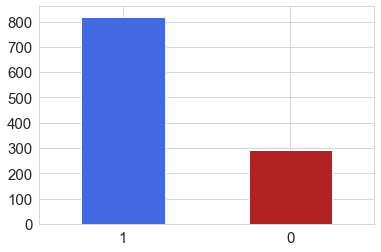

In [17]:
# Create a X matrix with the 1134 signatures I have
# Check if we are well balanced, not that well..
print("OBSERVATIONS KEPT")
print(len(dfcc), 'observations')
print(dfcc.p_np.value_counts())
dfcc.p_np.value_counts().plot.bar(color=['royalblue','firebrick'],rot=0,fontsize=15)

In [18]:
scaffoldsSeries= dfcc.smiles.groupby(dfcc.scaffold).agg(lambda x:list(x.index))
scaffoldsSeries

scaffold
C(/C=C/c1ccccc1)=C\c1ccccc1                                                       [947]
C(=C(c1ccccc1)c1ccccc1)c1ccccc1                                                   [345]
C(=Cc1ccccc1)c1ccccc1                                                             [185]
C(CCN1CCCCC1)=C(c1cccs1)c1cccs1                                                  [1607]
C(CCN1CCCCC1)=C1c2ccccc2Sc2ccccc21                                                [161]
                                                            ...                        
c1ncc2ncn(C3CCCO3)c2n1                                                            [391]
c1ncc2ncn([C@H]3CCCO3)c2n1                                                  [231, 2050]
c1ncn([C@H]2CCCO2)n1                                                              [383]
c1nncs1                                                                      [450, 959]
empty                                 [13, 122, 179, 200, 203, 227, 251, 257, 273, 2...
Name: smiles, Length: 5

### Making sure that train and test sets contain distinct scaffolds, while being stratified

In [19]:
X= formatArray(np.array(dfcc[currentSign].values))
y=dfcc.p_np.values
print('X',X.shape)
print('y',y.shape)

X (1110, 3200)
y (1110,)


In [20]:
# Rerun this until you are satisfied with the proportion of 1/0 and the proportion of molecules for test_set
if not RANDOM_SPLIT:
    print("Using stratified random split with scaffold preservation")
    test_lst=customSplitter(dfcc, INITCYCLES=300)
    df_test= dfcc.loc[test_lst]
    df_train=dfcc[~dfcc.index.isin(test_lst)]
    print('train',len(df_train))
    print('test',len(df_test))
    n1, n0 = df.p_np.value_counts()
    tr_1, tr_0= df_train.p_np.value_counts()
    te_1, te_0= df_test.p_np.value_counts()
    tot= tr_1 + tr_0 + te_1 + te_0
    print("Total number of observations", tot)
    print("Proportion for test set:", (te_1 + te_0)/tot)
    print('\n')
    print("Full data, balance 1 / 0 --> {:.2}/{:.2}".format(n1/(n1+n0),  n0/(n1+n0)))
    print("Train set, balance 1 / 0 --> {:.2}/{:.2}".format(tr_1/(tr_1+tr_0),  tr_0/(tr_1+tr_0)))
    print("Test set, balance 1 / 0 --> {:.2}/{:.2}".format(te_1/(te_1+te_0),  te_0/(te_1+te_0)))
    X_train = formatArray(df_train[currentSign].values)
    y_train = df_train.p_np.values

    X_test = formatArray(df_test[currentSign].values)
    y_test = df_test.p_np.values
    
    # Check that our train and test sets have different scaffolds
    print("Scaffold intersection:")
    print(set(df_train.scaffold).intersection(df_test.scaffold))
    
else:
    # Stratified random split
    print("Using stratified random split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Using stratified random split


In [21]:
def fitRF(nestim, maxd, minsplit, crit, maxf, y_true):
    rf= RandomForestClassifier(n_estimators=nestim,max_depth=maxd, min_samples_split=minsplit, criterion=crit, max_features=maxf)
    rf.fit(X_train,y_train)
    y_hat= rf.predict(X_test)
    
    return roc_auc_score(y_true,y_hat)

In [ ]:
dicResult=dict()
for nesti in (10,100,500,1000):
    for maxd in (None,5,10):
        for minsp in (2,3,10):
            for crit in ('gini', 'entropy'):
                for maxf in ('sqrt', 'log2'):
                    clef= str(nesti)+'_'+str(maxd)+'_'+str(minsp)+'_'+crit+'_'+maxf
                    dicResult[clef] = fitRF(nesti,maxd, minsp, crit, maxf, y_test)
print(dicResult)

In [ ]:
sorted([(k,v) for k,v in dicResult.items()], key=lambda t:t[1],reverse=True)

In [22]:
## Hyperparameter tuning
# defining parameter range 
param_grid_rf = {'n_estimators': [10,100,500,1000],  
              'max_depth': [None,5,10], 
              'min_samples_split': [2,3,10],
            'criterion': ['gini', 'entropy']
                 
                }  
  
#cv = [(slice(None), slice(None))]  # For NOT performing cross-validation
gridrf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit = True, verbose = 3,scoring='roc_auc',cv=5) 
  
# fitting the model for grid search 
gridrf.fit(X, y) 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10, score=0.7339293096320793, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10, score=0.8582842724978973, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10, score=0.8114486963835156, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10 
[CV]  criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10, score=0.8854604709840203, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10 
[CV]  criterion=gini, max_depth=None, min_samples_split=2, n_estimators=10, score=0.9308758197588323, total=   0.4s
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100, score=0.7673108722612649, total=   4.1s
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100, score=0.9223086627417999, total=   4.2s
[CV] criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=None, mi

[CV]  criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100, score=0.7546506821000414, total=   4.0s
[CV] criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100, score=0.9167367535744323, total=   4.1s
[CV] criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100, score=0.8799936921783011, total=   3.9s
[CV] criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100, score=0.9410218671152228, total=   3.9s
[CV] criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=None, min_samples_split=10, n_estimators=100, score=0.9769409773640786, total=   3.8s
[CV] criterion=gini, max_depth=None, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max

[CV]  criterion=gini, max_depth=5, min_samples_split=3, n_estimators=100, score=0.9752485720330019, total=   2.5s
[CV] criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500 
[CV]  criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500, score=0.7579578338156263, total=  12.5s
[CV] criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500 
[CV]  criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500, score=0.9300883095037847, total=  12.6s
[CV] criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500 
[CV]  criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500, score=0.8964991589571067, total=  12.4s
[CV] criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500 
[CV]  criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500, score=0.9606812447434819, total=  12.4s
[CV] criterion=gini, max_depth=5, min_samples_split=3, n_estimators=500 
[CV]  criterion=gini, max_depth=5, min_samples_split=3, n_estimat

[CV]  criterion=gini, max_depth=10, min_samples_split=2, n_estimators=500, score=0.9494322960470983, total=  19.0s
[CV] criterion=gini, max_depth=10, min_samples_split=2, n_estimators=500 
[CV]  criterion=gini, max_depth=10, min_samples_split=2, n_estimators=500, score=0.974931246033425, total=  18.9s
[CV] criterion=gini, max_depth=10, min_samples_split=2, n_estimators=1000 
[CV]  criterion=gini, max_depth=10, min_samples_split=2, n_estimators=1000, score=0.7641587432823481, total=  37.9s
[CV] criterion=gini, max_depth=10, min_samples_split=2, n_estimators=1000 
[CV]  criterion=gini, max_depth=10, min_samples_split=2, n_estimators=1000, score=0.9184188393608074, total=  37.8s
[CV] criterion=gini, max_depth=10, min_samples_split=2, n_estimators=1000 
[CV]  criterion=gini, max_depth=10, min_samples_split=2, n_estimators=1000, score=0.8923990748528176, total=  37.6s
[CV] criterion=gini, max_depth=10, min_samples_split=2, n_estimators=1000 
[CV]  criterion=gini, max_depth=10, min_samples_s

[CV]  criterion=gini, max_depth=10, min_samples_split=10, n_estimators=1000, score=0.8909272497897391, total=  36.8s
[CV] criterion=gini, max_depth=10, min_samples_split=10, n_estimators=1000 
[CV]  criterion=gini, max_depth=10, min_samples_split=10, n_estimators=1000, score=0.9534272497897394, total=  36.8s
[CV] criterion=gini, max_depth=10, min_samples_split=10, n_estimators=1000 
[CV]  criterion=gini, max_depth=10, min_samples_split=10, n_estimators=1000, score=0.9772583033636556, total=  36.9s
[CV] criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=10 
[CV]  criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=10, score=0.746486151302191, total=   0.4s
[CV] criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=10 
[CV]  criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=10, score=0.8986543313709, total=   0.4s
[CV] criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=10 
[CV]  criterion=entropy, max_

[CV]  criterion=entropy, max_depth=None, min_samples_split=3, n_estimators=1000, score=0.9731330653691558, total=  47.0s
[CV] criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10 
[CV]  criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10, score=0.7620917734601075, total=   0.4s
[CV] criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10 
[CV]  criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10, score=0.8836206896551724, total=   0.4s
[CV] criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10 
[CV]  criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10, score=0.8304247266610597, total=   0.4s
[CV] criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10 
[CV]  criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10, score=0.9258830950378468, total=   0.4s
[CV] criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=10 
[CV]

[CV]  criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=10, score=0.9025441547518922, total=   0.4s
[CV] criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=10 
[CV]  criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=10, score=0.8905067283431455, total=   0.4s
[CV] criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=10 
[CV]  criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=10, score=0.9394449116904962, total=   0.4s
[CV] criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=10 
[CV]  criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=10, score=0.9680558493759256, total=   0.4s
[CV] criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=100 
[CV]  criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=100, score=0.7611616370400991, total=   3.6s
[CV] criterion=entropy, max_depth=5, min_samples_split=3, n_estimators=100 
[CV]  criterion=entropy, max_depth=5, min_

[CV]  criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=10, score=0.9473238840702348, total=   0.4s
[CV] criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100, score=0.757027697395618, total=   4.1s
[CV] criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100, score=0.9182085786375105, total=   4.2s
[CV] criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100, score=0.8780487804878049, total=   4.1s
[CV] criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100, score=0.9388141295206056, total=   4.3s
[CV] criterion=entropy, max_depth=10, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, ma

[CV]  criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=100, score=0.9314550042052144, total=   4.2s
[CV] criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=100, score=0.9021761984861227, total=   4.0s
[CV] criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=100, score=0.9497476871320437, total=   4.1s
[CV] criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=100, score=0.9697482547070024, total=   4.2s
[CV] criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=500 
[CV]  criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=500, score=0.7612649855312111, total=  20.1s
[CV] criterion=entropy, max_depth=10, min_samples_split=10, n_estimators=500 
[CV]  criterion

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 90.1min finished
/home/nicolas/anaconda3/envs/sign/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 3, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [23]:
# That's the mean cross-validated score of the best_estimator
gridrf.best_score_

0.9089064856855675

In [28]:
rf_best= gridrf.best_estimator_

In [44]:
rf_best.score(Xz,yz)

0.9192680301399354

### Save this model

In [29]:
joblib.dump(rf_best,"../MLmodels/rf_from_signZ_paper_sign3cov_only.joblib")

['../MLmodels/rf_from_signZ_paper_sign3cov_only.joblib']

In [46]:
joblib.dump(gridrf,"../MLmodels/gridrf_signZsmall.pkl")

['../MLmodels/gridrf_signZsmall.pkl']

### Trying to predict the outcome of theremaining signZ

In [30]:
#All molecules that didn't have a sign3
Xz= df[(df.hassignZ==1) & (df.hassign3==0)].signZ.values
Xz = formatArray(Xz)
Xz

array([[-0.09497264,  0.09497266, -0.09497035, ...,  0.09495407,
        -0.09497111,  0.09448483],
       [-0.05148709,  0.10154025, -0.10691598, ...,  0.02905904,
        -0.0460031 ,  0.05124123],
       [ 0.08293382,  0.09479938, -0.09386682, ...,  0.1115393 ,
        -0.11433607, -0.05771599],
       ...,
       [ 0.10345946, -0.1038842 ,  0.08480205, ...,  0.06739628,
        -0.02878594,  0.08256143],
       [ 0.09245659, -0.03130475, -0.08344626, ...,  0.1748199 ,
         0.08100787, -0.01748343],
       [ 0.04738976,  0.10490414, -0.03515767, ..., -0.04212938,
         0.00790889, -0.10360762]], dtype=float32)

In [31]:
yz= df[(df.hassignZ==1) & (df.hassign3==0)].p_np.values
yz

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
yz_hat = rf_best.predict(Xz)
roc_auc_score(yz,yz_hat)

0.8144255893416028

In [43]:
# Using score 
rf_best.score(Xz,yz)

0.9192680301399354

In [ ]:
# Parameter space
param_space = {
    'n_estimators': hp.choice('n_estimators', (100,500,1000)),
    'max_depth': hp.choice('max_depth', (None,5,10)),
    'min_samples_split': hp.choice('min_samples_split', (2,3,10)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'max_features': hp.choice('max_features', ('sqrt', 'log2')) 
}

In [ ]:
#from sklearn.model_selection import cross_val_score

# I just copy again the code this function for easier readability
def rocModel(n_estimators, max_depth, min_samples_split, criterion, max_features):
    rf= RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion, max_features=max_features)
    rf.fit(X_train,y_train)
    y_hat= rf.predict(X_test)
    
    return roc_auc_score(y_test,y_hat)

best = 0
def f(params):
    global best
    acc = rocModel(**params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)



In [ ]:
# Try the best one with the signaturizer
# ('100_None_2_gini_sqrt', 0.8177773317275525)

rf= RandomForestClassifier(n_estimators=100,max_depth=None, min_samples_split=2, criterion='gini', max_features='sqrt')

In [ ]:
rf.fit(X_train,y_train)
y_hat= rf.predict(X_test)
print(roc_auc_score(y_test,y_hat))

# Trying a SVM

In [36]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_hat = clf.predict(X_test)

In [37]:
print(roc_auc_score(y_test,y_hat))

0.7676619007569386


In [38]:
# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': ['auto',1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  
  
#cv = [(slice(None), slice(None))]  # For NOT performing cross-validation
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3,scoring='roc_auc',cv=5) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] C=0.1, gamma=auto, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, gamma=auto, kernel=linear, score=0.9135130745492934, total=   1.5s
[CV] C=0.1, gamma=auto, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  C=0.1, gamma=auto, kernel=linear, score=0.9267500406041904, total=   1.6s
[CV] C=0.1, gamma=auto, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV]  C=0.1, gamma=auto, kernel=linear, score=0.9238265388988143, total=   1.6s
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV]  C=0.1, gamma=auto, kernel=linear, score=0.9160305343511452, total=   1.6s
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV]  C=0.1, gamma=auto, kernel=linear, score=0.8882343179555261, total=   1.5s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV]  C=0.1, gamma=auto, kernel=poly, score=0.8040441773591034, total=   1.9s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV]  C=0.1, gamma=auto, kernel=poly, score=0.8556114991067078, total=   1.9s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV]  C=0.1, gamma=auto, kernel=poly, score=0.9033620269611824, total=   2.0s
[CV] C=0.1, gamma=auto, kernel=poly ..................................
[CV]  C=0.1, gamma=auto, kernel=poly, score=0.8576169930302024, total=   2.0s
[CV] C=0.1, gamma=auto

[CV]  C=0.1, gamma=0.1, kernel=sigmoid, score=0.7763026883504813, total=   2.1s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV]  C=0.1, gamma=0.1, kernel=sigmoid, score=0.8221871888483238, total=   2.2s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, score=0.9135130745492934, total=   1.5s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, score=0.9267500406041904, total=   1.7s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, score=0.9238265388988143, total=   1.7s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, score=0.9160305343511452, total=   1.7s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, score=0.8882343179555261, total=   1.6s
[CV] C=0.1, ga

[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.8835048124792566, total=   2.2s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]  C=0.1, gamma=0.0001, kernel=rbf, score=0.8862429472286758, total=   2.2s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, score=0.8759948026636348, total=   2.1s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, score=0.9035244437225921, total=   2.1s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, score=0.9395809647555629, total=   2.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, score=0.8775307002987056, total=   2.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, score=0.8734649850647195, total=   2.0s
[

[CV]  C=1, gamma=0.1, kernel=poly, score=0.8971954862263526, total=   3.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.8763196361864544, total=   3.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.9249634562286827, total=   3.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.918954036056521, total=   3.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.904248257550614, total=   3.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.8933786923332226, total=   3.3s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV]  C=1, gamma=0.1, kernel=sigmoid, score=0.8068052623030696, total=   1.5s
[CV] C=1, gamma=0.1, kernel=sigmoid .................

[CV]  C=1, gamma=0.0001, kernel=poly, score=0.8040441773591034, total=   1.9s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.8556114991067078, total=   1.9s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.9033620269611824, total=   1.9s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.8576169930302024, total=   2.0s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.8215233986060405, total=   1.9s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.8839532239727139, total=   2.3s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.9215527042390774, total=   2.2s
[CV] C=1, gamma=0.0001, kernel

[CV]  C=10, gamma=0.1, kernel=linear, score=0.9157057008283255, total=   1.6s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV]  C=10, gamma=0.1, kernel=linear, score=0.9202533701477992, total=   1.6s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV]  C=10, gamma=0.1, kernel=linear, score=0.9057417855957518, total=   1.5s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV]  C=10, gamma=0.1, kernel=linear, score=0.8864088947892466, total=   1.5s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV]  C=10, gamma=0.1, kernel=poly, score=0.8665746305018679, total=   3.3s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV]  C=10, gamma=0.1, kernel=poly, score=0.918954036056521, total=   3.2s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV]  C=10, gamma=0.1, kernel=poly, score=0.906610362189378, total=   3.2s
[CV] C=10, gamma=0.1, kernel=poly ..

[CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.9386064641871041, total=   1.9s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.8866578161301029, total=   1.9s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.8973614337869233, total=   2.0s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV]  C=10, gamma=0.0001, kernel=linear, score=0.8839532239727139, total=   1.5s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV]  C=10, gamma=0.0001, kernel=linear, score=0.9157057008283255, total=   1.5s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV]  C=10, gamma=0.0001, kernel=linear, score=0.9202533701477992, total=   1.6s
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV]  C=10, gamma=0.0001, kernel=linear, score=0.9057417855957518, total=   1.5s
[CV] C=

[CV]  C=100, gamma=1, kernel=rbf, score=0.8419684911482865, total=   3.6s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV]  C=100, gamma=1, kernel=rbf, score=0.8411881845336873, total=   3.6s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV]  C=100, gamma=1, kernel=rbf, score=0.8404414205111184, total=   3.6s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV]  C=100, gamma=1, kernel=sigmoid, score=0.5573331167776514, total=   2.3s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV]  C=100, gamma=1, kernel=sigmoid, score=0.46662335553029066, total=   2.2s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV]  C=100, gamma=1, kernel=sigmoid, score=0.38557739158681176, total=   2.2s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV]  C=100, gamma=1, kernel=sigmoid, score=0.42067706604712907, total=   2.2s
[CV] C=100, gamma=1, kernel=sigmoid .

[CV]  C=100, gamma=0.001, kernel=poly, score=0.9155432840669157, total=   2.3s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV]  C=100, gamma=0.001, kernel=poly, score=0.9052439429140392, total=   2.3s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV]  C=100, gamma=0.001, kernel=poly, score=0.8862429472286758, total=   2.4s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.9019814844891993, total=   1.6s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.9251258729900925, total=   1.7s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.9299983758323858, total=   1.7s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.924161964819117, total=   1.6s
[CV] C=100, gamma=0.001, k

[CV]  C=1000, gamma=1, kernel=linear, score=0.9202533701477992, total=   1.7s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV]  C=1000, gamma=1, kernel=linear, score=0.9057417855957518, total=   1.5s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV]  C=1000, gamma=1, kernel=linear, score=0.8864088947892466, total=   1.5s
[CV] C=1000, gamma=1, kernel=poly ....................................
[CV]  C=1000, gamma=1, kernel=poly, score=0.8665746305018679, total=   3.2s
[CV] C=1000, gamma=1, kernel=poly ....................................
[CV]  C=1000, gamma=1, kernel=poly, score=0.918954036056521, total=   3.2s
[CV] C=1000, gamma=1, kernel=poly ....................................
[CV]  C=1000, gamma=1, kernel=poly, score=0.906610362189378, total=   3.3s
[CV] C=1000, gamma=1, kernel=poly ....................................
[CV]  C=1000, gamma=1, kernel=poly, score=0.9110521075340192, total=   3.2s
[CV] C=1000, gamma=1, kernel=poly ....

[CV]  C=1000, gamma=0.01, kernel=sigmoid, score=0.9178171187266525, total=   1.6s
[CV] C=1000, gamma=0.01, kernel=sigmoid ..............................
[CV]  C=1000, gamma=0.01, kernel=sigmoid, score=0.9010952538997676, total=   1.5s
[CV] C=1000, gamma=0.01, kernel=sigmoid ..............................
[CV]  C=1000, gamma=0.01, kernel=sigmoid, score=0.8855791569863922, total=   1.4s
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV]  C=1000, gamma=0.001, kernel=linear, score=0.8839532239727139, total=   1.5s
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV]  C=1000, gamma=0.001, kernel=linear, score=0.9157057008283255, total=   1.5s
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV]  C=1000, gamma=0.001, kernel=linear, score=0.9202533701477992, total=   1.6s
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV]  C=1000, gamma=0.001, kernel=linear, score=0.9057417855957518, total=   1.5s


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 36.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto', 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [39]:
grid.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [40]:
grid.best_score_

0.9162800540988412

In [41]:
y_hat=grid.predict(X_test)

### SAVE

In [45]:
grid.best_estimator_.score(Xz,yz)

0.9246501614639397

In [42]:
print(roc_auc_score(y_test,y_hat))

0.7545206055508831
